In [1]:
import cirq
import numpy as np
import random
import sympy
from math import pi
import time
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pennylane.optimize import NesterovMomentumOptimizer
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

%matplotlib inline

np.random.seed(42)

Number of processors:  12


In [2]:
def U_phi(q, W):
    for i in range(len(q)):
        rot = cirq.ZPowGate(exponent=W[i]/pi)
        yield rot(q[i])
    for i in range(len(q)-1):
        for j in range(i+1,len(q)):
            rot = cirq.ZPowGate(exponent=((pi-W[i])*(pi-W[j]))/pi)
            yield rot.on(q[j]).controlled_by(q[i])
            
def fancy_U(q, W):
    for i in range(len(q)):
        yield cirq.H(q[i])
    yield U_phi(q, W)
    for i in range(len(q)):
        yield cirq.H(q[i])
    yield U_phi(q, W)

def W_theta(q, theta):
    for i in range(len(q)):
        yield cirq.CZ.on(q[(i+1)%len(q)],q[i])
    for i in range(len(q)):
        rot = cirq.ZPowGate(exponent=theta[2*i]/pi)
        yield rot(q[i])
        rot = cirq.Ry(theta[2*i+1])
        yield rot(q[i])

def measure(q):
    for i in range(len(q)):
        yield cirq.measure(q[i], key=str(i))

In [3]:
def circuit(q, W, theta, layers):
    yield fancy_U(q,W)
    for i in range(len(q)):
        rot = cirq.ZPowGate(exponent = theta[2*i]/pi)
        yield rot(q[i])
        rot = cirq.Ry(theta[2*i + 1])
        yield rot(q[i])
    
    for i in range(1,layers+1):
        yield W_theta(q, theta[range(6*(i),6*(i+1))])
    yield measure(q)

In [19]:
def abs_loss(labels, predictions):
    loss=0
    pred = np.round(predictions)
    for l, p in zip(labels, pred):
        loss = loss + np.abs(l - p)
    loss = loss / len(labels)
    return loss

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p)**2
    loss = loss/ len(labels)
    return loss

def accuracy(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)
    return loss

def prediction(results):
    counter = (results.multi_measurement_histogram(keys="012"))
    p_hold = 0
    for j in counter:
        if j.count(1) % 2 == 1:
            p_hold += counter[j] 
    return p_hold/shots

def variational_classifier(q, x, theta, l, shots):
    simulator = cirq.Simulator()
    c = cirq.Circuit()
    c.append(circuit(q, x, theta, l))
    return simulator.run(c, repetitions=shots)
        
def cost(theta, X, Y, q, l, batch_i, shots, key):
    p = []
    for i in batch_i:
        results = variational_classifier(q, X[i], theta, l, shots)
        p.append(prediction(results))
    return square_loss(Y[batch_i], p)


def cost2(theta, X, Y, q, l, batch_i, shots, key):
    p = []
    pool2 = mp.Pool(mp.cpu_count()-2)
    results = pool2.starmap(variational_classifier,[(q, X[i], theta, l, shots) for i in batch_i])
    for i in results:
        p.append(prediction(i))
    pool2.close()
    return square_loss(Y[batch_i], p)

In [17]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
	"""
	Call in a loop to create terminal progress bar
	@params:
		iteration   - Required  : current iteration (Int)
		total	   - Required  : total iterations (Int)
		prefix	  - Optional  : prefix string (Str)
		suffix	  - Optional  : suffix string (Str)
		decimals	- Optional  : positive number of decimals in percent complete (Int)
		length	  - Optional  : character length of bar (Int)
		fill		- Optional  : bar fill character (Str)
	"""
	percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
	filledLength = int(length * iteration // total)
	bar = fill * filledLength + '-' * (length - filledLength)
	print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
	# Print New Line on Complete
	if iteration == total: 
		print()

30.576812505722046 sec████████████████████████████████████---| 95.6% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
init_theta - end_theta: 
[-0.907 -5.213 -0.393 -5.134 -0.054 -1.43  -0.604 -0.275 -0.297 -6.123
 -0.668 -5.963 -0.465  0.014 -0.376 -0.366 -4.494 -0.089]
gradient: 
[-0.01790779 -1.10694444 -1.34824437 -0.10987494  0.40095246 -0.36877913
 -0.08377205  0.26436759  0.0734523   0.60340158 -0.95063066 -0.26892042
 -0.51750487 -0.2091266  -0.56455077 -1.10330218  0.58731492  0.32051915]


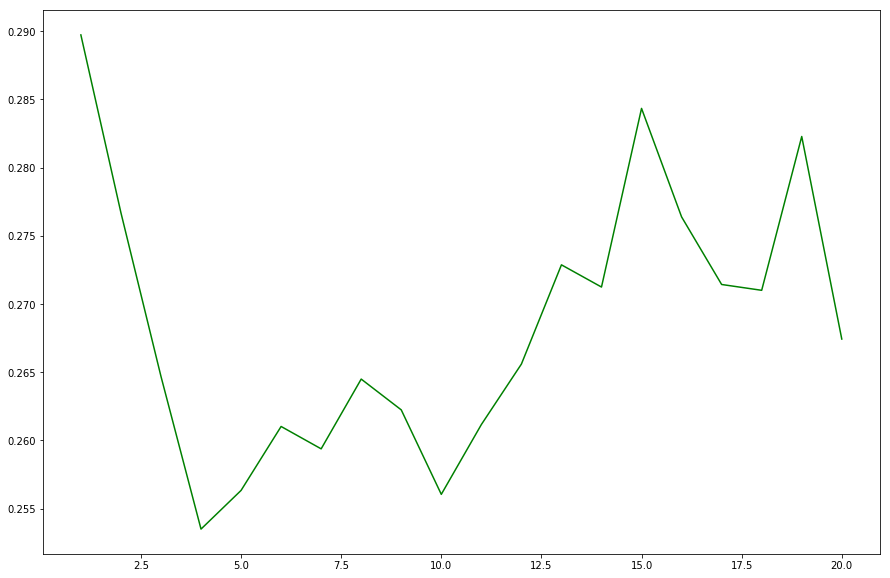

In [33]:
nr_qubits = 3
nr_layers = 2
batch_size = 10
shots = 100
iterations = 20
key = ""
for i in range(nr_qubits):
    key += str(i)

#Set up input and output qubits.
qubits = [cirq.GridQubit(i, 0) for i in range(nr_qubits)]

df = pd.read_csv("QA_data.csv")
X = df.iloc[:,:3].to_numpy()
Y = df.iloc[:,3].to_numpy()

m = int(np.round((2/3)*len(X)))
train = np.random.randint(0, len(X), (m,))
X_t = X[train,:]
Y_t = Y[train]

nr_par = (nr_qubits*2)*(nr_layers+1)
init_theta = np.array(0.01*np.random.rand(nr_par,)*(2*pi))
theta = init_theta
iz = np.array(range(m))
eye = np.eye(nr_par)
c = 0.1
a = 2*pi*0.1
alpha = 0.602
gamma = 0.101
plot_ix = 10
P = int(iterations/plot_ix)
tot_loss = np.zeros(iterations)
opt = NesterovMomentumOptimizer(0.5)

pool = mp.Pool(mp.cpu_count()-2)
start = time.time()
for k in range(1,iterations+1):
    printProgressBar((k-1)*nr_par, iterations*nr_par, prefix = 'Progress:', suffix = "Complete", length = 50)
    batch_ix = np.random.randint(0, len(X), (batch_size,))
    c_n = c/(k**(0.602))
    a_n = a/(k**(0.101))
    printProgressBar((k-1)*nr_par+i, iterations*nr_par, prefix = 'Progress:', suffix = 'Complete', length = 50)
    loss_plus = pool.starmap(cost,[(theta+c_n*eye[:,i], X, Y, qubits, nr_layers, batch_ix, shots, key) for i in range(nr_par)])
    loss_minus= pool.starmap(cost,[(theta-c_n*eye[:,i], X, Y, qubits, nr_layers, batch_ix, shots, key) for i in range(nr_par)])
    gradient = (np.array(loss_plus) - np.array(loss_minus))/(2*c_n)
    theta = (theta - a_n*gradient) % (2*pi)
    tot_loss[k-1] = cost2(theta, X_t, Y_t, qubits, nr_layers, iz, shots, key)
    results = pool.starmap(variational_classifier,[(qubits, x, theta, nr_layers, int(shots/10)) for x in X])
    predictions = [np.sign(prediction(i)) for i in results] 
    acc = accuracy(Y, predictions)
pool.close()
end = time.time()
print(end-start,"sec")
    
printProgressBar(iterations*nr_par, iterations*nr_par, prefix = 'Progress:', suffix = 'Complete', length = 50)

print("init_theta - end_theta: ")
print(np.around(init_theta-theta,3))
print("gradient: ")
print(gradient)
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
plt.plot(range(1,iterations+1), tot_loss, 'g-', markersize=2)

In [6]:
pool = mp.Pool(mp.cpu_count()-2)
start = time.time()
for k in range(1,iterations+1):
    result1 = [pool.apply(cost,args=(theta+c_n*eye[:,i], X, Y, qubits, nr_layers, batch_ix, shots, key)) for i in range(nr_par)]

end = time.time()
print("parallel time: ", round(end-start,3))
start = time.time()
for k in range(1,iterations+1):
    result2 = [cost(theta+c_n*eye[:,i], X, Y, qubits, nr_layers, batch_ix, shots, key) for i in range(nr_par)]
end = time.time()
print("non parallel time: ", round(end-start,3))
# print(result1)
# print(result2)

NameError: name 'iterations' is not defined

Process ForkPoolWorker-5:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/martijn/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/martijn/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/martijn/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/martijn/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/martijn/anaconda3/lib/python3.7/multiproce